In [1]:
import psycopg2
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import time

In [2]:
conn = psycopg2.connect(dbname =   'sync3', 
                        user =     'postgres', 
                        password = 'sync3',
                        host =     '141.100.70.97')

SQL_business = """SELECT business.bid, business.clusterid, business.stars, business.revcount, 
                    business.name,
                    categories.cid, categories.cat, category.bid, category.cid
                  FROM business
                  INNER JOIN category
                    ON category.bid = business.bid
                  INNER JOIN categories
                    ON categories.cid = category.cid
                    AND categories.cat in ('Food','Restaurants','Nightlife')
                  WHERE business.revcount > 50
               """

SQL_wetter = """SELECT clusterid, date, tmin, tmax, snow, snowdepth, perception
                FROM cluster_weather
             """

SQL_reviews = """SELECT bid, star, date, interactions
                 FROM reviews
             """

In [3]:
start = time.time()
wetter = pd.read_sql_query(SQL_wetter, conn)
end = time.time()
print(f"Wetter-Daten geladen in {str(round(end-start,2))}")

start = time.time()
business = pd.read_sql_query(SQL_business, conn)
end = time.time()
print(f"Business-Daten geladen in {str(round(end-start,2))}")

start = time.time()
reviews = pd.read_sql_query(SQL_reviews, conn)
end = time.time()
print(f"Review-Daten geladen in {str(round(end-start,2))}")

Wetter-Daten geladen in 2.84
Business-Daten geladen in 1.5
Review-Daten geladen in 185.13


In [4]:
# Clean DF
business = business.loc[:,~business.columns.duplicated()]
wetter = wetter.loc[:,~wetter.columns.duplicated()]
reviews = reviews.loc[:,~reviews.columns.duplicated()]

# Filter Reviews
bids = business['bid'].to_numpy().tolist()
revs = reviews[reviews['bid'].isin(bids)].reset_index()

# Rename DF
df_b = business.dropna()
df_w = wetter.dropna()
df_r = revs.dropna()

# Monat und Jahr Spalte
df_w["year"] = pd.DatetimeIndex(df_w['date']).year
df_w["month"] = pd.DatetimeIndex(df_w['date']).month
df_r["year"] = pd.DatetimeIndex(df_r['date']).year
df_r["month"] = pd.DatetimeIndex(df_r['date']).month

C:\Users\Melanie\anaconda3\lib\site-packages\ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()
C:\Users\Melanie\anaconda3\lib\site-packages\ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


# Fehlende Daten

## Cluster-Wetter

In [5]:
print(f"tmin:\t\t {str(round(sum(wetter['tmin'].isnull()/len(wetter))*100,4))} %")
print(f"tmax:\t\t {str(round(sum(wetter['tmax'].isnull()/len(wetter))*100,4))} %")
print(f"snow:\t\t {str(round(sum(wetter['snow'].isnull()/len(wetter))*100,4))} %")
print(f"snowdepth:\t {str(round(sum(wetter['snowdepth'].isnull()/len(wetter))*100,4))} %")
print(f"perception:\t {str(round(sum(wetter['perception'].isnull()/len(wetter))*100,4))} %")

tmin:		 0.0517 %
tmax:		 0.0339 %
snow:		 0.1131 %
snowdepth:	 0.771 %
perception:	 0.0178 %


# Plots

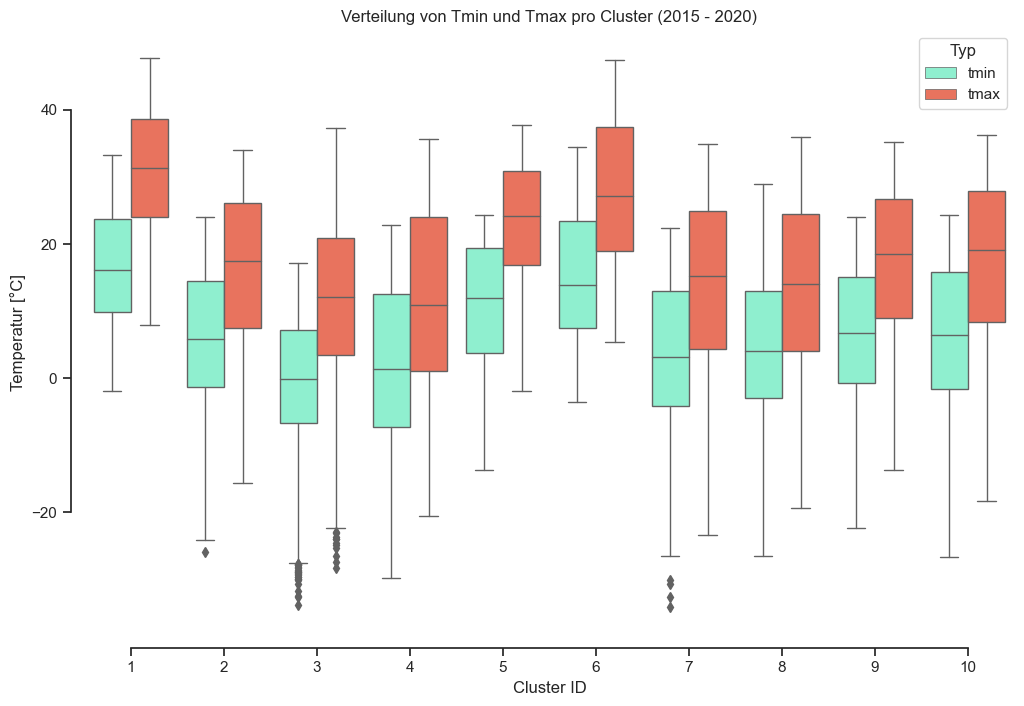

In [6]:
year_min = 2015
year_max = 2020

df_years = df_w[df_w['year'].isin(range(year_min,year_max+1))]
plot_df = df_years.melt(id_vars=['clusterid'], var_name='temp_type', value_name='values')
plot_df1 = plot_df[plot_df['temp_type'].isin(['tmin','tmax'])]
      
plt.figure(figsize=(12,8), dpi= 100)
colors=['aquamarine','tomato']
sns.set(style='ticks')
sns.boxplot(x='clusterid', y='values', hue = 'temp_type', data=plot_df1,
               palette=colors, linewidth=1, hue_order = ['tmin','tmax'])
plt.legend(title='dataset', loc='upper left', bbox_to_anchor=(1, 1))
plt.title(f"Verteilung von Tmin und Tmax pro Cluster ({str(year_min)} - {str(year_max)})")
plt.xlabel('Cluster ID')
plt.ylabel('Temperatur [°C]')
plt.legend(title = 'Typ')
sns.despine(offset=10, trim=True)

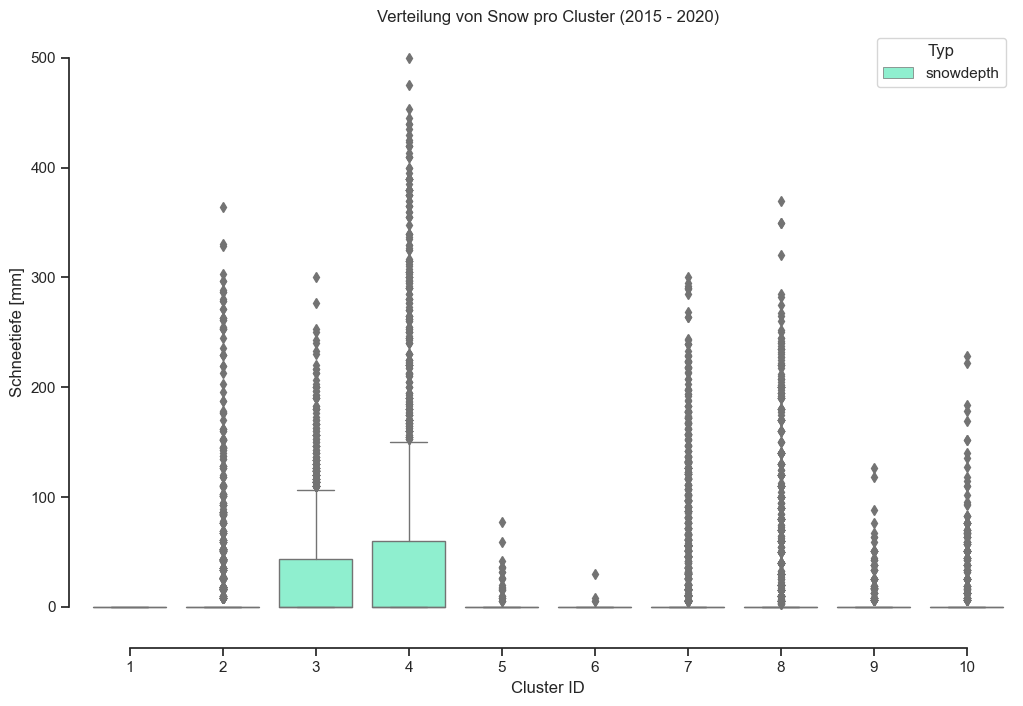

In [7]:
year_min = 2015
year_max = 2020

df_years = df_w[df_w['year'].isin(range(year_min,year_max+1))]
plot_df = df_years.melt(id_vars=['clusterid'], var_name='temp_type', value_name='values')
plot_df1 = plot_df[plot_df['temp_type'].isin(['snowdepth'])]
      
plt.figure(figsize=(12,8), dpi= 100)
colors=['aquamarine','tomato']
sns.set(style='ticks')
sns.boxplot(x='clusterid', y='values', hue = 'temp_type', data=plot_df1,
               palette=colors, linewidth=1)
plt.legend(title='dataset', loc='upper left', bbox_to_anchor=(1, 1))
plt.title(f"Verteilung von Snow pro Cluster ({str(year_min)} - {str(year_max)})")
plt.xlabel('Cluster ID')
plt.ylabel('Schneetiefe [mm]')
plt.legend(title = 'Typ')
sns.despine(offset=10, trim=True)

## Histogramme für Wettervariablen pro Cluster

Text(0.5, 0.98, 'Histogramme perception pro Cluster')

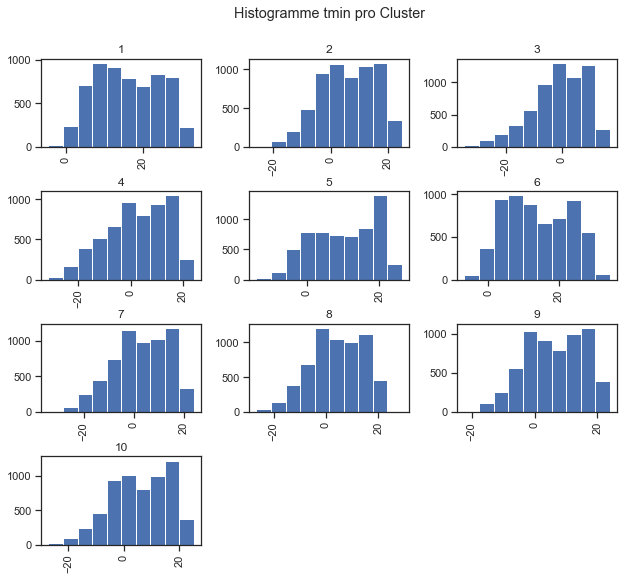

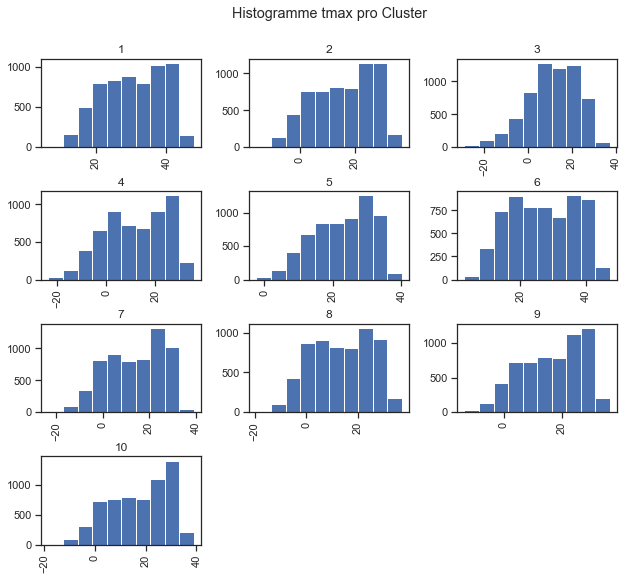

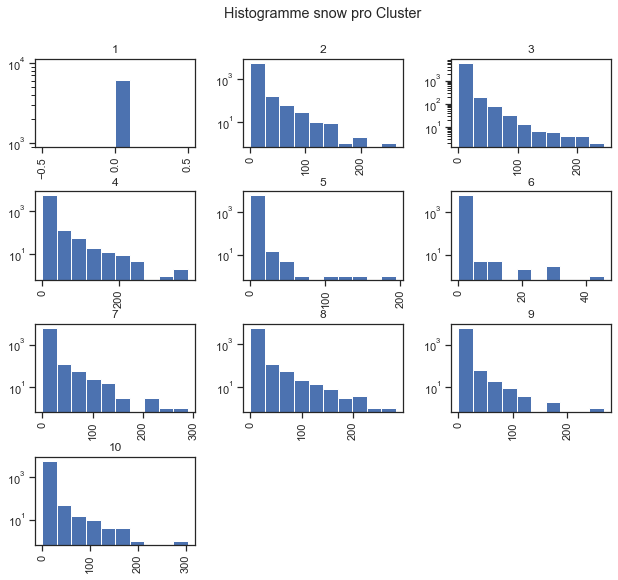

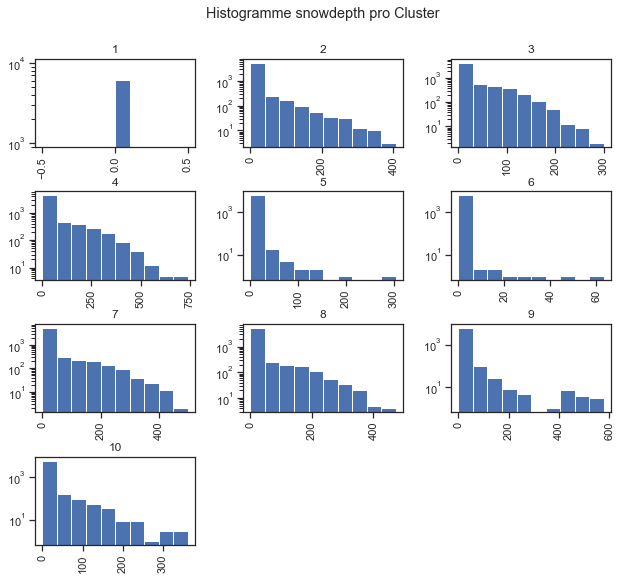

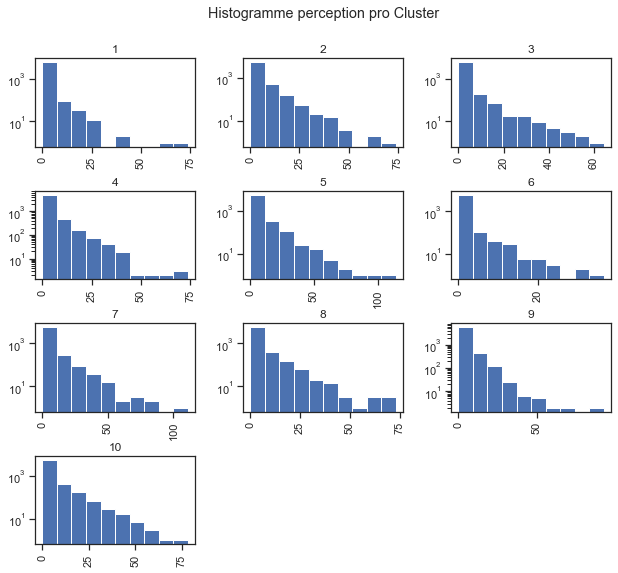

In [8]:
df_w['tmin'].hist(by = df_w['clusterid'], figsize=(10,9))
plt.suptitle('Histogramme tmin pro Cluster')

df_w['tmax'].hist(by = df_w['clusterid'], figsize=(10,9))
plt.suptitle('Histogramme tmax pro Cluster')

df_w['snow'].hist(by = df_w['clusterid'], log = True, figsize=(10,9))
plt.suptitle('Histogramme snow pro Cluster')

df_w['snowdepth'].hist(by = df_w['clusterid'], log = True, figsize=(10,9))
plt.suptitle('Histogramme snowdepth pro Cluster')

df_w['perception'].hist(by = df_w['clusterid'], log = True, figsize=(10,9))
plt.suptitle('Histogramme perception pro Cluster')

## Beliebteste Businesses pro Cluster (stars + revcount)

In [9]:
top_n = 5

for c in range(1,11):
    gr_df = df_b[(df_b.clusterid == c) & (df_b.stars >= 4)].drop_duplicates(subset = 'bid',keep='first')\
        .sort_values(by = ['stars','revcount'], ascending = False)
    print('------------------------------------------------------------------------\n')
    print(f"Beliebteste Restaurants Cluster {str(c)} \n")
    print(gr_df[['name','cat','stars','revcount']].head(top_n).to_string(index=False))
    print('\n\n')

------------------------------------------------------------------------

Beliebteste Restaurants Cluster 1 

                    name          cat  stars  revcount
         Little Miss BBQ  Restaurants    5.0      2329
         Cocina Madrigal  Restaurants    5.0      1107
 Green Corner Restaurant  Restaurants    5.0       858
          Worth Takeaway  Restaurants    5.0       842
         Kodo Sushi Sake  Restaurants    5.0       695



------------------------------------------------------------------------

Beliebteste Restaurants Cluster 2 

                                       name          cat  stars  revcount
  Mitchell's Homemade Ice Cream - Cleveland         Food    5.0       391
 EDWINS Leadership and Restaurant Institute  Restaurants    5.0       191
                             In Forno Pizza  Restaurants    5.0       177
                              Express Deli   Restaurants    5.0       176
                                      Munch  Restaurants    5.0       160





## Beliebteste Businesses pro Cluster (revcount)

In [10]:
top_n = 5

for c in range(1,11):
    gr_df = df_b[(df_b.clusterid == c)].drop_duplicates(subset = 'bid',keep='first')\
    .sort_values(by = 'revcount', ascending = False)
    print('------------------------------------------------------------------------\n')
    print(f"Beliebteste Restaurants Cluster {str(c)} \n")
    print(gr_df[['name','cat','stars','revcount']].head(top_n).to_string(index=False))
    print('\n\n')

------------------------------------------------------------------------

Beliebteste Restaurants Cluster 1 

                   name          cat  stars  revcount
 Snooze, An A.M. Eatery  Restaurants    4.0      3515
                Bobby Q  Restaurants    4.5      3302
        Pizzeria Bianco  Restaurants    4.0      2527
     Four Peaks Brewing    Nightlife    4.5      2400
       Joe's Farm Grill  Restaurants    4.0      2369



------------------------------------------------------------------------

Beliebteste Restaurants Cluster 2 

                        name          cat  stars  revcount
                    Townhall    Nightlife    4.0      1372
       The Greenhouse Tavern  Restaurants    3.5      1104
            West Side Market         Food    4.5      1084
                        Lola    Nightlife    4.0      1078
 Great Lakes Brewing Company  Restaurants    4.0       995



------------------------------------------------------------------------

Beliebteste Restaurant

## Reviews pro Cluster

   clusterid    revcount
0          1  217.825474
1          2  132.535471
2          3   92.535055
3          4  134.485687
4          5  159.558577
5          6  338.424523
6          7  142.825025
7          8  130.865803
8          9  159.009250
9         10  122.695502


<Figure size 1440x576 with 0 Axes>

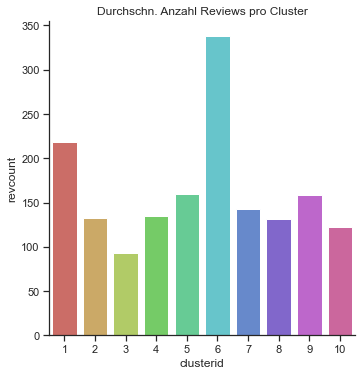

   clusterid  revcount
0          1   2101798
1          2    330676
2          3     50154
3          4    140941
4          5    475325
5          6   2591655
6          7    140397
7          8    697253
8          9    326605
9         10     35459


<Figure size 1440x576 with 0 Axes>

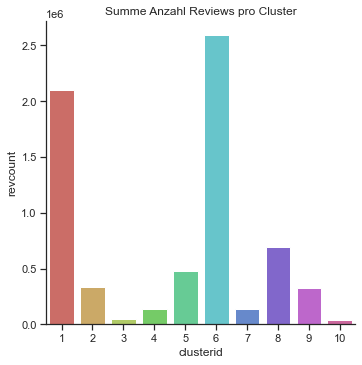

In [11]:
plot_df = df_b.groupby(by = 'clusterid', as_index=False)['revcount'].mean()
print(plot_df)
plt.figure(figsize = (20,8))
sns.set(style='ticks')
sns.catplot(x = 'clusterid',
            y = 'revcount',
            #hue = "clusterid",
            data = plot_df,
            kind = 'bar',
            palette = 'hls',
            ci = None)
plt.title('Durchschn. Anzahl Reviews pro Cluster')
plt.show()

plot_df = df_b.groupby(by = 'clusterid', as_index=False)['revcount'].sum()
print(plot_df)
plt.figure(figsize = (20,8))
sns.set(style='ticks')
sns.catplot(x = 'clusterid',
            y = 'revcount',
            #hue = "clusterid",
            data = plot_df,
            kind = 'bar',
            palette = 'hls',
            ci = None)
plt.title('Summe Anzahl Reviews pro Cluster')
plt.show()

## Tabellen-Merge

In [12]:
df_r_b = pd.merge(df_r, df_b, how = 'left', on='bid')
df_r_w = pd.merge(df_r_b, df_w, how = 'left', on=['date','clusterid'])

In [13]:
df_res = df_r_w.drop(columns = ['cid','cat','year_y','month_y'])

## Klassierungen der Variablen

In [14]:
df_res['tmin_cat'] = pd.cut(df_res['tmin'], bins=[-35, -20, -10, 0, 10, 20, 35], right=False)
df_res['tmax_cat'] = pd.cut(df_res['tmax'], bins=[-30, -10, 0, 10, 20, 30, 40, 50], right=False)
df_res['snow_cat'] = pd.cut(df_res['snow'], bins=[0, 50, 100, 200, 1000], right=False)
df_res['snowdepth_cat'] = pd.cut(df_res['snowdepth'], bins=[0, 50, 100, 200, 1000], right=False)
df_res['perception_cat'] = pd.cut(df_res['perception'], bins=[0, 25, 50, 75, 1000], right=False)

# Plots: Durchschnittliche Sterne bzw. Interactions pro Cluster nach Wettermerkmal-Kategorie

In [15]:
def plotStarWeather(data, var, year_start, year_end, clusterid, calc_avg):
    cat = var + '_cat'
    data = data.groupby(['year_x',cat,'clusterid'], as_index=False)[var,'star','interactions'].mean()
    data = data[(data['year_x'] >= year_start) & (data['year_x'] <= year_end)\
                                   & (data['clusterid'] == clusterid)]
    if calc_avg == True:
        plot_df = data.groupby(by = [cat], as_index=False)['star'].mean()
        hue = None
    else: 
        plot_df = data.groupby(by = ['year_x',cat], as_index=False)['star'].mean()
        hue = 'year_x'
    plt.figure(figsize = (20,8))
    sns.set(style='ticks')
    sns.catplot(x = cat,
               y = 'star',
               hue = hue,
               data = plot_df,
               kind = 'bar',
               palette = 'hls')
    plt.title(f"Durchsch. Sterne pro Cluster {str(clusterid)}")
    plt.show()

def plotInteractionsWeather(data, var, year_start, year_end, clusterid, calc_avg):
    cat = var + '_cat'
    data = data.groupby(['year_x',cat,'clusterid'], as_index=False)[var,'star','interactions'].mean()
    data = data[(data['year_x'] >= year_start) & (data['year_x'] <= year_end)\
                                   & (data['clusterid'] == clusterid)]
    
    if calc_avg == True:
        plot_df = data.groupby(by = [cat], as_index=False)['interactions'].mean()
        hue = None
    else: 
        plot_df = data.groupby(by = ['year_x',cat], as_index=False)['interactions'].mean()
        hue = 'year_x'
    plt.figure(figsize = (20,8))
    sns.set(style="ticks")
    sns.catplot(x = cat,
               y = 'interactions',
               hue = hue,
               data = plot_df,
               kind = 'bar',
               palette = 'hls')
    plt.title(f"Durchsch. Interaktionen pro Cluster {str(clusterid)}")
    plt.show()
    

C:\Users\Melanie\anaconda3\lib\site-packages\ipykernel_launcher.py:3: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  This is separate from the ipykernel package so we can avoid doing imports until


<Figure size 1440x576 with 0 Axes>

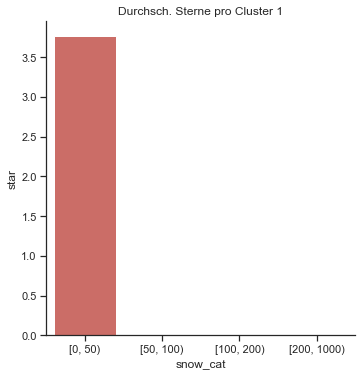

C:\Users\Melanie\anaconda3\lib\site-packages\ipykernel_launcher.py:3: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  This is separate from the ipykernel package so we can avoid doing imports until


<Figure size 1440x576 with 0 Axes>

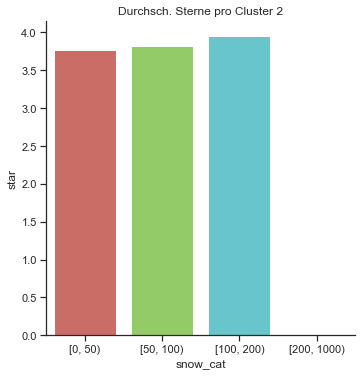

C:\Users\Melanie\anaconda3\lib\site-packages\ipykernel_launcher.py:3: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  This is separate from the ipykernel package so we can avoid doing imports until


<Figure size 1440x576 with 0 Axes>

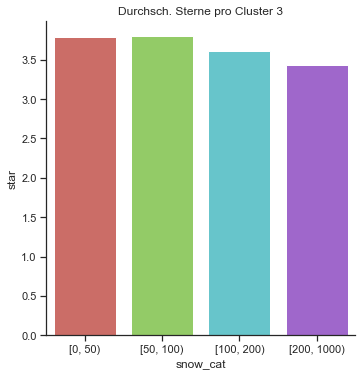

C:\Users\Melanie\anaconda3\lib\site-packages\ipykernel_launcher.py:3: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  This is separate from the ipykernel package so we can avoid doing imports until


<Figure size 1440x576 with 0 Axes>

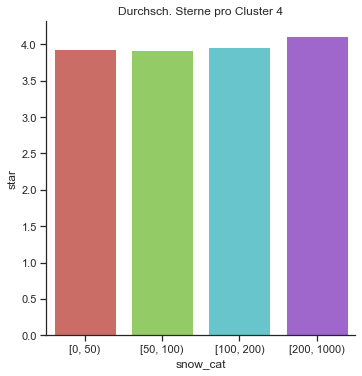

C:\Users\Melanie\anaconda3\lib\site-packages\ipykernel_launcher.py:3: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  This is separate from the ipykernel package so we can avoid doing imports until


<Figure size 1440x576 with 0 Axes>

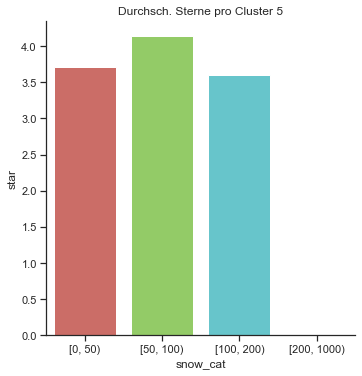

C:\Users\Melanie\anaconda3\lib\site-packages\ipykernel_launcher.py:3: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  This is separate from the ipykernel package so we can avoid doing imports until


<Figure size 1440x576 with 0 Axes>

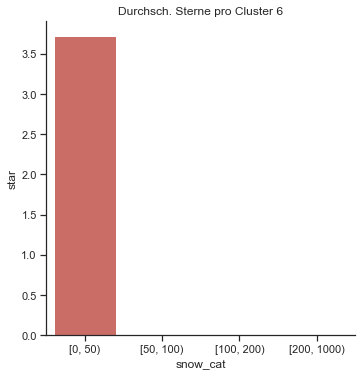

C:\Users\Melanie\anaconda3\lib\site-packages\ipykernel_launcher.py:3: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  This is separate from the ipykernel package so we can avoid doing imports until


<Figure size 1440x576 with 0 Axes>

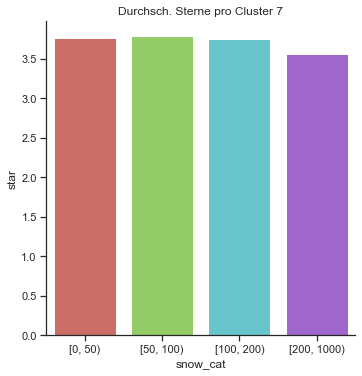

C:\Users\Melanie\anaconda3\lib\site-packages\ipykernel_launcher.py:3: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  This is separate from the ipykernel package so we can avoid doing imports until


<Figure size 1440x576 with 0 Axes>

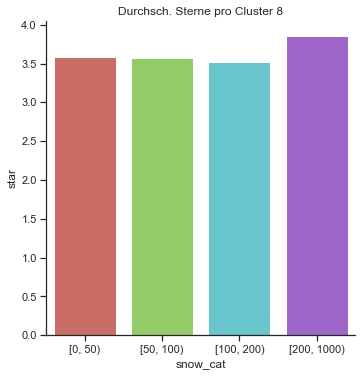

C:\Users\Melanie\anaconda3\lib\site-packages\ipykernel_launcher.py:3: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  This is separate from the ipykernel package so we can avoid doing imports until


<Figure size 1440x576 with 0 Axes>

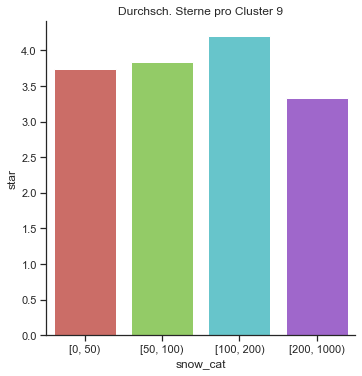

C:\Users\Melanie\anaconda3\lib\site-packages\ipykernel_launcher.py:3: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  This is separate from the ipykernel package so we can avoid doing imports until


<Figure size 1440x576 with 0 Axes>

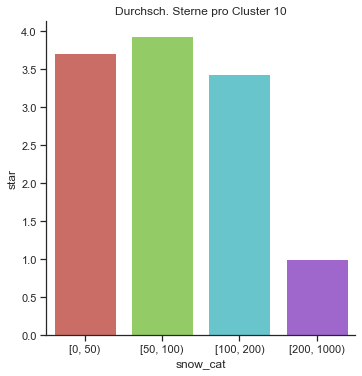

In [16]:
for c in range(1,11):
    plotStarWeather(df_res, 'snow', 2010, 2015, c, True)

C:\Users\Melanie\anaconda3\lib\site-packages\ipykernel_launcher.py:25: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.


<Figure size 1440x576 with 0 Axes>

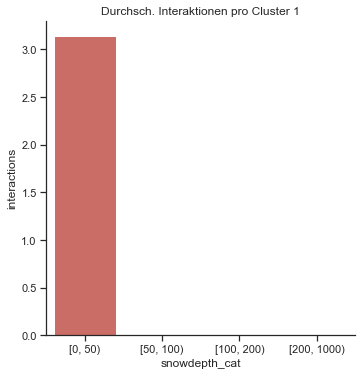

C:\Users\Melanie\anaconda3\lib\site-packages\ipykernel_launcher.py:25: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.


<Figure size 1440x576 with 0 Axes>

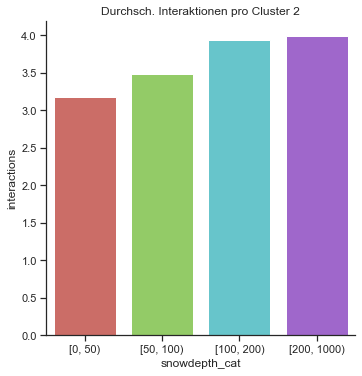

C:\Users\Melanie\anaconda3\lib\site-packages\ipykernel_launcher.py:25: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.


<Figure size 1440x576 with 0 Axes>

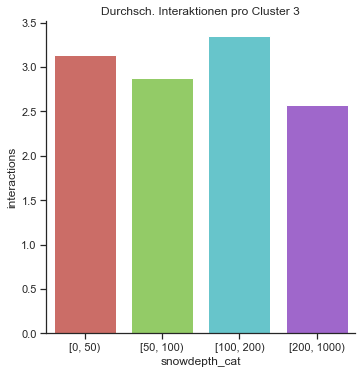

C:\Users\Melanie\anaconda3\lib\site-packages\ipykernel_launcher.py:25: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.


<Figure size 1440x576 with 0 Axes>

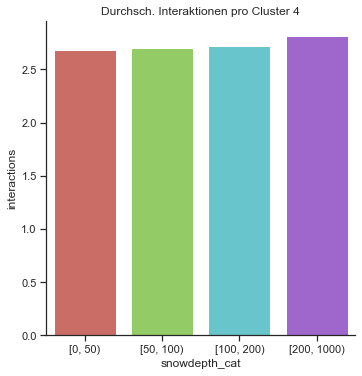

C:\Users\Melanie\anaconda3\lib\site-packages\ipykernel_launcher.py:25: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.


<Figure size 1440x576 with 0 Axes>

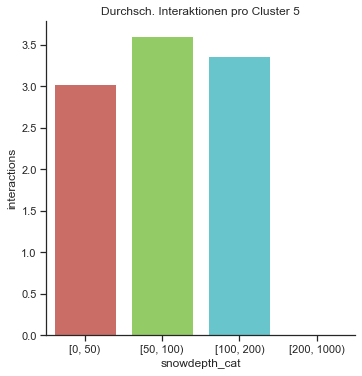

C:\Users\Melanie\anaconda3\lib\site-packages\ipykernel_launcher.py:25: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.


<Figure size 1440x576 with 0 Axes>

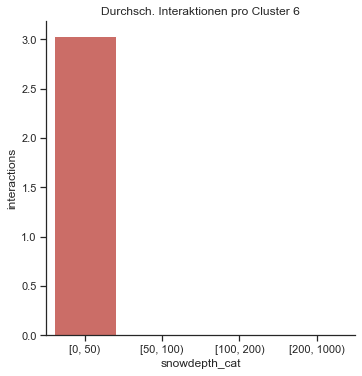

C:\Users\Melanie\anaconda3\lib\site-packages\ipykernel_launcher.py:25: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.


<Figure size 1440x576 with 0 Axes>

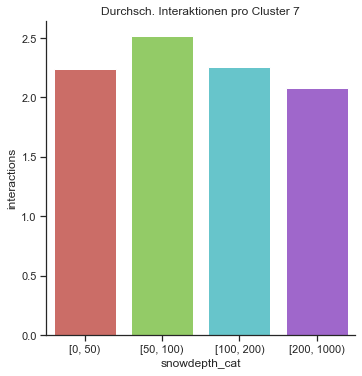

C:\Users\Melanie\anaconda3\lib\site-packages\ipykernel_launcher.py:25: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.


<Figure size 1440x576 with 0 Axes>

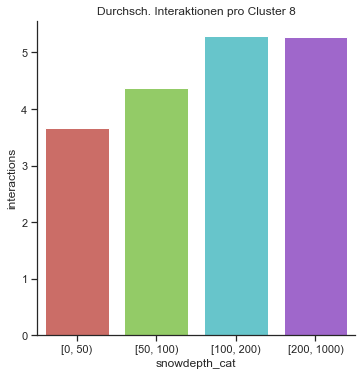

C:\Users\Melanie\anaconda3\lib\site-packages\ipykernel_launcher.py:25: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.


<Figure size 1440x576 with 0 Axes>

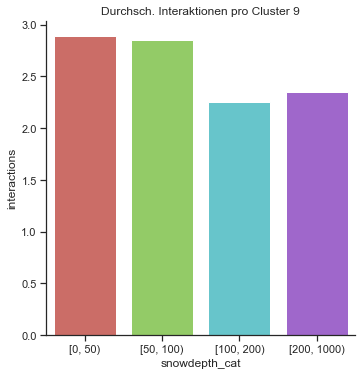

C:\Users\Melanie\anaconda3\lib\site-packages\ipykernel_launcher.py:25: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.


<Figure size 1440x576 with 0 Axes>

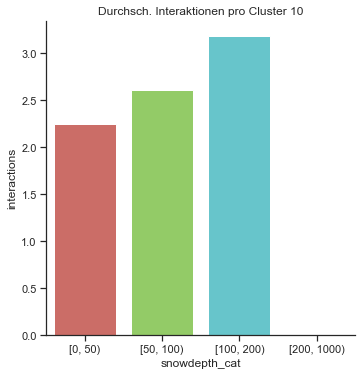

In [17]:
for c in range(1,11):
    plotInteractionsWeather(df_res, 'snowdepth', 2010, 2012, c, True)